In [13]:
!pip -q install lightgbm==4.* scikit-learn pandas numpy matplotlib
from google.colab import drive
drive.mount('/content/drive')

# 把这个路径改成你Drive里存放CSV的目录，或直接指向某个CSV文件
DATA_PATH = "/content/drive/MyDrive/INCS870/CICIoT2023"   # 目录：会自动合并目录下 *.csv
print("DATA_PATH =", DATA_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATA_PATH = /content/drive/MyDrive/INCS870/CICIoT2023


In [19]:
# ===== Robust Loader + Auto Label + Preprocess + Split =====
import os, glob, re, time, json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 路径 & 标签列（一般保持 label 即可）
DATA_PATH = "/content/drive/MyDrive/INCS870/CICIoT2023"  # ← 改成你的目录或CSV；也可用通配符
LABEL_COL = "label"                                      # 自动生成/映射到这个列名
TEST_SIZE = 0.2
RANDOM_STATE = 42

def infer_label_from_path(path: str) -> str:
    """从文件名/父目录推断标签（Benign / DDoS_TCP / DDoS_UDP...）"""
    name = os.path.basename(path).lower()
    parent = os.path.basename(os.path.dirname(path)).lower()
    s = name + " " + parent
    if "benign" in s:
        return "Benign"
    if "ddos" in s and "tcp" in s:
        return "DDoS_TCP"
    if "ddos" in s and "udp" in s:
        return "DDoS_UDP"
    return os.path.basename(os.path.dirname(path)) or os.path.splitext(os.path.basename(path))[0]

def load_data(path: str) -> pd.DataFrame:
    """读取数据：
    - 文件：直接读；若无标签列则自动添加
    - 目录：递归找所有 .csv/.csv.gz；逐个读并补上标签列再合并
    - 通配符：按通配符匹配读
    """
    def _read_one(f):
        if f.lower().endswith(".csv.gz"):
            df = pd.read_csv(f, compression="gzip", low_memory=False)
        else:
            df = pd.read_csv(f, low_memory=False)
        # 若已存在标签列，统一映射到 LABEL_COL
        existing = [c for c in df.columns if c.lower() in
                    ("label","labels","class","attack","attack_type","category","benign_final")]
        if existing:
            df = df.rename(columns={existing[0]: LABEL_COL})
        else:
            df[LABEL_COL] = infer_label_from_path(f)
        return df

    if any(ch in path for ch in ["*","?","["]):  # 通配符
        files = sorted(glob.glob(path, recursive=True))
    elif os.path.isdir(path):                     # 目录：递归
        files = []
        for r,_,fs in os.walk(path):
            for n in fs:
                if n.lower().endswith((".csv",".csv.gz")):
                    files.append(os.path.join(r,n))
    else:                                         # 单文件
        files = [path]

    if not files:
        raise FileNotFoundError("没有找到任何 CSV 文件")
    print(f"发现 {len(files)} 个CSV")
    frames = [_read_one(f) for f in files]
    return pd.concat(frames, ignore_index=True)

# -------- 1) 读入 --------
df = load_data(DATA_PATH)
print("shape(raw):", df.shape, "; label示例：", df[LABEL_COL].unique()[:10])

# -------- 2) 轻度清洗 --------
drop_cols = [c for c in df.columns if c.lower() in ["id","flow_id","time","timestamp"] and c != LABEL_COL]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

y = df[LABEL_COL].astype("category")
X = df.drop(columns=[LABEL_COL])

# -------- 3) 编码/缺失/降精度 --------
cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype) == "bool"]
if cat_cols:
    X = pd.get_dummies(X, columns=cat_cols, dummy_na=False)

X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
for c in X.columns:
    if np.issubdtype(X[c].dtype, np.floating):
        X[c] = X[c].astype("float32")
    elif np.issubdtype(X[c].dtype, np.integer):
        X[c] = X[c].astype("int32")

print("shape(after preprocess):", X.shape, "; classes:", list(y.cat.categories))

# -------- 4) 切分 --------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print("train/test shapes:", X_train.shape, X_test.shape)



发现 4 个CSV
shape(raw): (741787, 40) ; label示例： ['Benign' 'DDoS_TCP' 'DDoS_UDP']
shape(after preprocess): (741787, 39) ; classes: ['Benign', 'DDoS_TCP', 'DDoS_UDP']
train/test shapes: (593429, 39) (148358, 39)


In [20]:
# ===== Train & Evaluate (Baseline / GOSS / EFB / GOSS+EFB) with callbacks early stopping =====
import os, time, json
import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

os.makedirs("results", exist_ok=True)
print("LightGBM version:", lgb.__version__)

# 0) 可选：去掉常量列，避免无意义特征拖慢速度
const_cols = [c for c in X_train.columns if X_train[c].nunique() <= 1]
if const_cols:
    X_train = X_train.drop(columns=const_cols)
    X_test  = X_test.drop(columns=[c for c in const_cols if c in X_test], errors="ignore")
    print(f"已移除常量列 {len(const_cols)} 个")

def _with_bundle_alias(params: dict, flag: bool):
    """同时设置 is_enable_bundle / enable_bundle 两个别名，避免版本差异"""
    p = dict(params)
    p["is_enable_bundle"] = flag
    p["enable_bundle"] = flag
    return p

def run_cfg(name: str, params: dict):
    # 验证集用于早停（与训练集同分布）
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    n_classes = len(y_train.cat.categories) if hasattr(y_train, "cat") else len(np.unique(y_train))
    metric = "multi_logloss" if n_classes > 2 else "logloss"

    model = LGBMClassifier(
        n_estimators=3000,          # 给足上限，用早停决定实际棵树
        learning_rate=0.05,
        num_leaves=64,
        max_depth=-1,
        subsample=1.0,              # 公平：Baseline 也不 bagging
        colsample_bytree=0.9,
        reg_lambda=1.0,
        class_weight="balanced",    # 如需关闭：改为 None
        n_jobs=-1,
        random_state=42,
        verbosity=-1,               # 安静一些
        **params
    )

    callbacks = [
        lgb.early_stopping(stopping_rounds=100, verbose=False),
        lgb.log_evaluation(period=0),  # 关闭eval日志
    ]

    t0 = time.perf_counter()
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric=metric,
        callbacks=callbacks
    )
    train_time = time.perf_counter() - t0
    best_iter = getattr(model, "best_iteration_", None) or model.n_estimators

    # 评估
    y_pred = model.predict(X_test, num_iteration=best_iter)
    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    rpt = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    minority_recalls = {k: v["recall"] for k, v in rpt.items()
                        if k not in ["accuracy", "macro avg", "weighted avg"]}
    min_rec = min(minority_recalls.values()) if minority_recalls else float("nan")
    cm = confusion_matrix(y_test, y_pred, labels=(y.cat.categories if hasattr(y, "cat") else None))

    res = {
        "name": name,
        "train_time_sec": round(train_time, 3),
        "best_iter": int(best_iter),
        "test_acc": round(acc, 4),
        "macro_f1": round(macro_f1, 4),
        "minority_recall_min": round(min_rec, 4),
        "classes": list(y.cat.categories) if hasattr(y, "cat") else None,
        "confusion_matrix": cm.tolist(),
        "params": params
    }
    print(json.dumps(res, indent=2, ensure_ascii=False))
    with open(f"results/{name}_results.json", "w", encoding="utf-8") as f:
        json.dump(res, f, ensure_ascii=False, indent=2)
    return res

# -------- 四组配置 --------
# BLS：basic GBDT + bagging，EFB off
baseline = run_cfg(
    "Baseline-GBDT-noEFB",
    _with_bundle_alias(dict(boosting="gbdt", data_sample_strategy="bagging"), False)
)

# GOSS：one-side sampling，EFB off
goss = run_cfg(
    "GOSS",
    _with_bundle_alias(dict(data_sample_strategy="goss", top_rate=0.2, other_rate=0.1), False)
)

# EFB-only：only EFB，keep GBDT + bagging
efb = run_cfg(
    "EFB-only",
    _with_bundle_alias(dict(boosting="gbdt", data_sample_strategy="bagging"), True)
)

# GOSS + EFB：both
goss_efb = run_cfg(
    "GOSS+EFB",
    _with_bundle_alias(dict(data_sample_strategy="goss", top_rate=0.2, other_rate=0.1), True)
)

# 汇总表（PPT 直接贴）
df_res = pd.DataFrame([baseline, goss, efb, goss_efb])[
    ["name", "train_time_sec", "best_iter", "test_acc", "macro_f1", "minority_recall_min"]
]
df_res



LightGBM version: 4.6.0
{
  "name": "Baseline-GBDT-noEFB",
  "train_time_sec": 48.897,
  "best_iter": 178,
  "test_acc": 0.9999,
  "macro_f1": 1.0,
  "minority_recall_min": 0.9999,
  "classes": [
    "Benign",
    "DDoS_TCP",
    "DDoS_UDP"
  ],
  "confusion_matrix": [
    [
      25967,
      0,
      0
    ],
    [
      0,
      53153,
      2
    ],
    [
      0,
      7,
      69229
    ]
  ],
  "params": {
    "boosting": "gbdt",
    "data_sample_strategy": "bagging",
    "is_enable_bundle": false,
    "enable_bundle": false
  }
}
{
  "name": "GOSS",
  "train_time_sec": 67.624,
  "best_iter": 186,
  "test_acc": 0.9999,
  "macro_f1": 1.0,
  "minority_recall_min": 0.9999,
  "classes": [
    "Benign",
    "DDoS_TCP",
    "DDoS_UDP"
  ],
  "confusion_matrix": [
    [
      25967,
      0,
      0
    ],
    [
      0,
      53154,
      1
    ],
    [
      0,
      7,
      69229
    ]
  ],
  "params": {
    "data_sample_strategy": "goss",
    "top_rate": 0.2,
    "other_rate": 0.1

,name,train_time_sec,best_iter,test_acc,macro_f1,minority_recall_min
0,Baseline-GBDT-noEFB,48.897,178,0.9999,1.0000,0.9999
1,GOSS,67.624,186,0.9999,1.0000,0.9999
2,EFB-only,79.893,310,0.9999,0.9999,0.9999
3,GOSS+EFB,111.504,292,0.9999,0.9999,0.9999


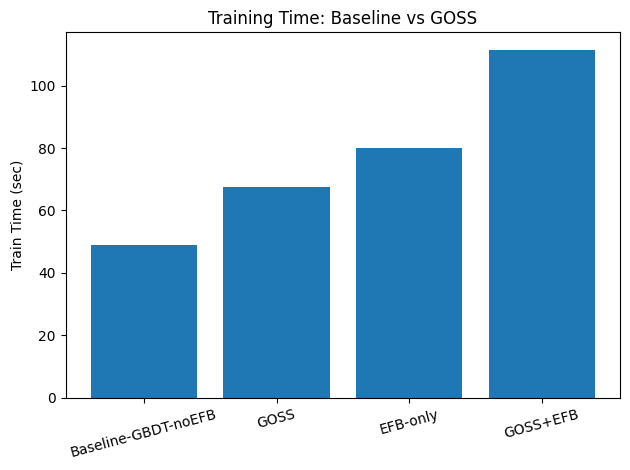

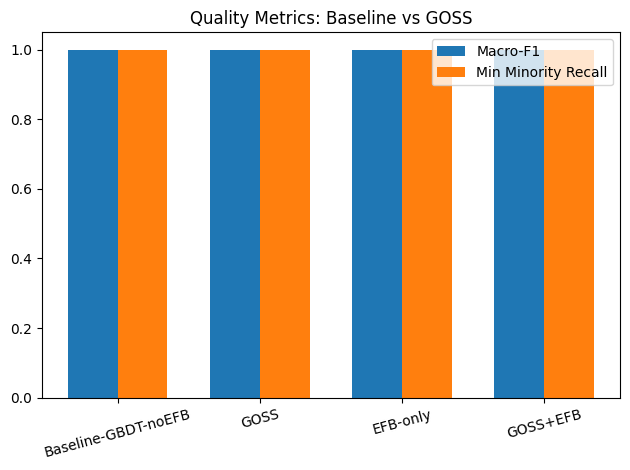

图已保存：results/time_bar.png, results/quality_bar.png


In [21]:
import matplotlib.pyplot as plt

# 训练时长
plt.figure()
plt.bar(df_res["name"], df_res["train_time_sec"])
plt.ylabel("Train Time (sec)")
plt.title("Training Time: Baseline vs GOSS")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("results/time_bar.png", dpi=200)
plt.show()

# 宏F1与最小少数类召回
plt.figure()
width = 0.35
x = np.arange(len(df_res))
plt.bar(x - width/2, df_res["macro_f1"], width, label="Macro-F1")
plt.bar(x + width/2, df_res["minority_recall_min"], width, label="Min Minority Recall")
plt.xticks(x, df_res["name"], rotation=15)
plt.title("Quality Metrics: Baseline vs GOSS")
plt.legend()
plt.tight_layout()
plt.savefig("results/quality_bar.png", dpi=200)
plt.show()

print("图已保存：results/time_bar.png, results/quality_bar.png")
